In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

# Dataset Generation

In [ ]:
def Data_generator(n, dim, n_slabs):
  n_per_slab = n // n_slabs
  X = torch.zeros((n, 2))
  Y = torch.zeros((n,))

  start = 0.75

  for slab in range(n_slabs):
    X[slab * n_per_slab : (slab + 1) * n_per_slab, 1] = (0.25) * torch.rand(n_per_slab) + start - (0.25 + 0.1875) * slab

    if(slab % 2 != 0):
      X[slab * n_per_slab: (slab + 1) * n_per_slab, 0] = (1 + 0.05825) * torch.rand(n_per_slab) - 0.05825
      Y[slab * n_per_slab: (slab + 1) * n_per_slab] = 1
    else:
      X[slab * n_per_slab: (slab + 1) * n_per_slab, 0] = (0.05825 + 1) * torch.rand(n_per_slab) - 1
      Y[slab * n_per_slab: (slab + 1) * n_per_slab] = 0

  idx = torch.arange(n)
  random.shuffle(idx)

  X = X[idx,:]
  Y = Y[idx]

  for i in range(2, dim):
    x = torch.randn((n,1))
    X = torch.hstack([X, x])

  return X,Y

In [ ]:
X,Y = Data_generator(100000, 10, 5)
print(X.shape, Y.shape)

torch.Size([100000, 10]) torch.Size([100000])


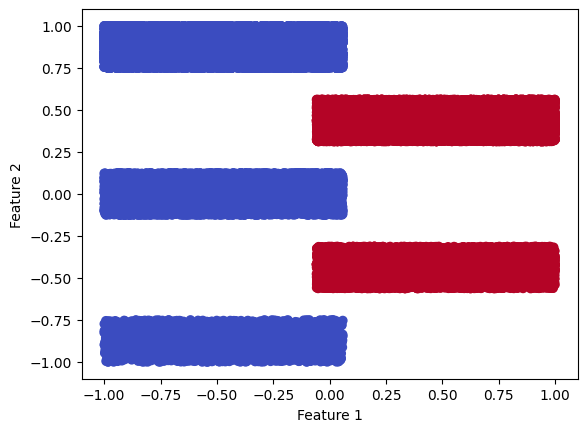

In [ ]:
plt.scatter(X[:, 0], X[: ,1], c =Y, cmap='coolwarm')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

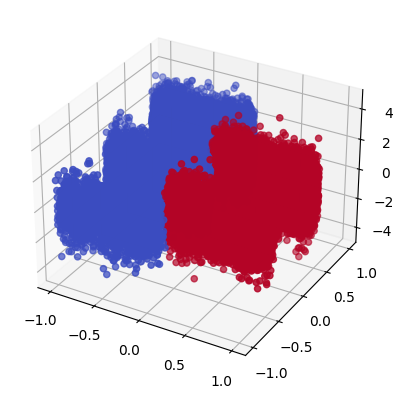

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c = Y, cmap='coolwarm')
plt.show()

# Neural Network Model

In [ ]:
class FCN(nn.Module):

  def __init__(self, params):
    super().__init__()

    self.layers = nn.ModuleList()

    cdim = params['in_size']

    for hdim in params['hlayers']:
      self.layers.append(nn.Linear(cdim, hdim))
      self.layers.append(nn.ReLU())
      cdim = hdim

    self.layers.append(nn.Linear(cdim, params['out_size']))

  def forward(self, X):
    for layer in self.layers:
      X = layer(X)
    X = F.sigmoid(X)
    return X


def train(params, loss_func, num_epochs, batch_size, x_train, y_train, x_test, y_test,verbose=True):
  model = FCN(params)
  loss_arr =[]
  n_batchs = x_train.shape[0] // batch_size

  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epochs):
    for i in range(n_batchs):
      x = x_train[i*batch_size: (i+1) * batch_size]
      y = y_train[i*batch_size: (i+1) * batch_size].reshape((-1, 1))

      out = model(x)
      optimizer.zero_grad()
      loss = loss_func(out, y)
      loss.backward()
      optimizer.step()

    loss_arr.append(loss.detach())
    if verbose:
      print(f"Epoch{epoch}  : {loss}")

  with torch.no_grad():
    out_test = model(x_test)
    out_test[out_test < 0.5] = 0
    out_test[out_test >= 0.5] = 1

    loss_acc = balanced_accuracy_score(out_test, y_test)
    if verbose:
      print(f"test accuracy: {loss_acc}")

  return model, loss_arr

# Training the model

In [ ]:
X_train, Y_train = Data_generator(100000, 50, 5)
X_test, Y_test = Data_generator(10000, 50, 5)

Y_train.reshape((-1, 1)).long()
Y_test.reshape((-1, 1)).long()

tensor([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [0]])

In [ ]:
params = {
    'in_size' : 50,
    'hlayers' : [32],
    'out_size': 1
}

loss_fnc = nn.BCELoss()

In [ ]:
batch_size = 64
n_batchs = 100000 // batch_size
num_epochs = 5

net,losses = train(params, loss_fnc, num_epochs, batch_size, X_train, Y_train, X_test, Y_test, True)

Epoch0  : 0.11510719358921051
Epoch1  : 0.1019739881157875
Epoch2  : 0.10123588889837265
Epoch3  : 0.1001514196395874
Epoch4  : 0.10065323114395142
test accuracy: 0.9565748038311768


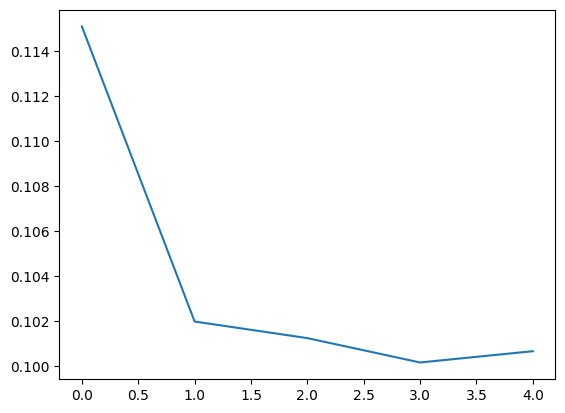

In [ ]:
plt.plot(range(num_epochs), losses)
plt.show()

# Decision Boundary

In [ ]:
def Decision_Boundary(X, model):
  dc_X = torch.zeros(X.shape)
  dist = torch.distributions.uniform.Uniform(low=-1, high=1)

  dc_X[:, 0] = dist.rsample((X.shape[0], ))
  dc_X[:, 1] = dist.rsample((X.shape[0], ))

  for i in range(2, 10):
    dc_X[:, i] = torch.randn((X.shape[0], ))

  dc_out = model(dc_X)
  dc_out[dc_out < 0.5] = 0
  dc_out[dc_out >= 0.5] = 1

  plt.scatter(dc_X[:, 0], dc_X[:, 1], c=dc_out.detach(), cmap='coolwarm')
  plt.show()

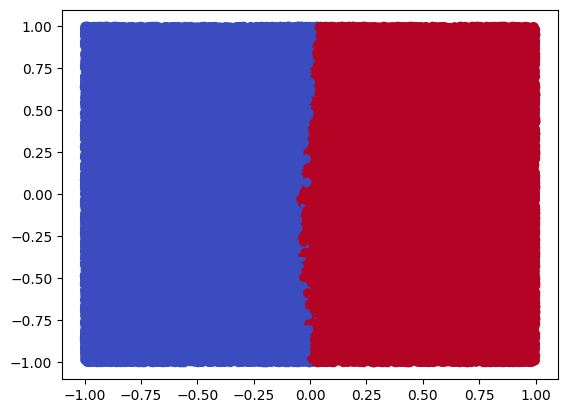

In [ ]:
Decision_Boundary(X_train, net)

# Deeper Network

In [ ]:
# 2 hidden layer with 32 neurons each
dep_net_params = {
    'in_size' : 50,
    'hlayers' : [32, 32],
    'out_size' : 1
}

dep_net, losses_ = train(dep_net_params, loss_fnc, num_epochs, batch_size, X_train, Y_train, X_test, Y_test)

plt.plot(range(len(losses_)), losses_)
plt.show()

In [ ]:
Decision_Boundary(X_train, dep_net)

In [ ]:
# Hidden layers: 32 32 16 16
dep_net1_params = {
    "in_size" : 50,
    "hlayers": [32, 32, 16, 16],
    'out_size': 1
}

dep_net1, losses_1 = train(dep_net1_params, loss_fnc,num_epochs,  batch_size, X_train, Y_train, X_test, Y_test)

plt.plot(range(len(losses_1)), losses_1)
plt.show()

In [ ]:
Decision_Boundary(X_train, dep_net1)

In [ ]:
# Hidden Layers: 32 32 32 32 16 16
dep_net2_params = {
    "in_size" : 50,
    "hlayers": [32, 32, 32, 32, 16, 16],
    'out_size': 1
}

dep_net2, losses_2 = train(dep_net2_params, loss_fnc,num_epochs,  batch_size, X_train, Y_train, X_test, Y_test)

plt.plot(range(len(losses_2)), losses_2)
plt.show()

In [ ]:
Decision_Boundary(X_train, dep_net2)

# Effect of epochs in smaller nets

In [ ]:
num_epochs = 20

net_epoch, losses_epoch = train(params, loss_fnc, num_epochs, batch_size, X_train, Y_train, X_test, Y_test)

plt.plot(range(len(losses_epoch)), losses_epoch)
plt.show()

In [ ]:
Decision_Boundary(X_train, net_epoch)

In [ ]:
num_epochs = 50

net_epoch1, losses_epoch = train(params, loss_fnc, num_epochs, batch_size, X_train, Y_train, X_test, Y_test)

plt.plot(range(len(losses_epoch)), losses_epoch)
plt.show()

In [ ]:
Decision_Boundary(X_train, net_epoch1)

In [ ]:
epochs = []

# Effect of Dimension of data

In [ ]:
dim1 = 100
X_train1, Y_train1 = Data_generator(100000, dim1, 5)
X_test1, Y_test1 = Data_generator(10000, dim1, 5)
params['in_size'] = dim1

dep_net_dim, loss_dim = train(params, loss_fnc, 10, batch_size, X_train1, Y_train1, X_test1, Y_test1)

plt.plot(range(len(loss_dim)), loss_dim)
plt.show()

In [ ]:
Decision_Boundary(X_train1, dep_net_dim)

In [ ]:
dims = [50, 100, 200, 300,400, 500, 600, 700,  800, 900, 1000]
losses = []

for dim in dims:
  x, y = Data_generator(100000, dim, 5)
  x_, y_ = Data_generator(10000, dim, 5)

  params['in_size'] = dim
  net, loss = train(params, loss_fnc, 10, batch_size, x, y, x_, y_, False)

  y_out = net(x_)
  y_out[y_out <  0.5] = 0
  y_out[y_out >= 0.5] = 1

  test_acc = balanced_accuracy_score(y_out.detach(), y_)
  losses.append(test_acc)

plt.plot(dims, losses)
plt.xlabel("Input dimensions")
plt.ylabel("Test Accuracy")
plt.show()

# Effect of Ensembling

In [ ]:
def ensemble_train(n_nets, params, loss_func, epochs, batch_size, x, y, x_, y_, verbose = True):

  loss_arr =[]
  n_batchs = x.shape[0] // batch_size

  networks = [FCN(params) for i in range(n_nets)]

  for net in networks:
    optimizer = optim.Adam(net.parameters(), lr=1e-3)

    for epoch in range(epochs):
      for i in range(n_batchs):
        _x = x[i*batch_size: (i+1) * batch_size]
        _y = y[i*batch_size: (i+1) * batch_size].reshape((-1, 1))

        out = net(_x)
        optimizer.zero_grad()
        loss = loss_func(out, _y)
        loss.backward()
        optimizer.step()

      loss_arr.append(loss.detach())
      if verbose:
        print(f"Epoch{epoch}  : {loss}")

  return networks

def ensemble_test(nets, x_):
  Out = []

  for net in nets:
    with torch.no_grad():
      out = net(x_)
    out[out < 0.5] = 0
    out[out >= 0.5] = 1

    if nets.index(net) != 0:
      Out.append(out)

  Out = torch.hstack(Out)
  Out,_ = torch.mode(Out, -1)
  return Out

In [ ]:
n_nets = 100
params = {
    'in_size': 50,
    'hlayers' : [32],
    'out_size' : 1
}

X_train,Y_train = Data_generator(100000, 50, 5)
X_test, Y_test = Data_generator(10000, 50, 5)

nets = ensemble_train(n_nets, params, loss_fnc, 5, batch_size, X_train, Y_train, X_test, Y_test, verbose=False)
out  = ensemble_test(nets, X_test)

In [ ]:
dc_X = torch.zeros(X_train.shape)
dist = torch.distributions.uniform.Uniform(low=-1, high=1)

dc_X[:, 0] = dist.rsample((X.shape[0], ))
dc_X[:, 1] = dist.rsample((X.shape[0], ))

for i in range(2, 50):
  dc_X[:, i] = torch.randn((X.shape[0], ))

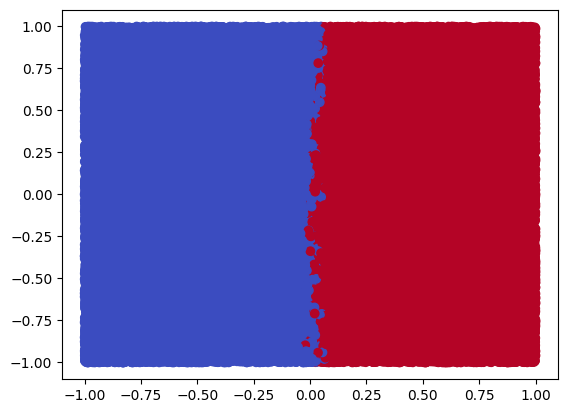

In [ ]:
dec_out = ensemble_test(nets, dc_X)
plt.scatter(dc_X[:,0], dc_X[:,1], c = dec_out, cmap='coolwarm')
plt.show()

# Dropout layer

In [ ]:
class FCN_dropout(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(50 , 32)
    self.fc2 = nn.Linear(32, 1)
    self.drop = nn.Dropout(0.5)

  def forward(self, X):
    x = F.relu(self.fc1(X))
    x = self.drop(x)
    x = F.sigmoid(self.fc2(x))
    return x

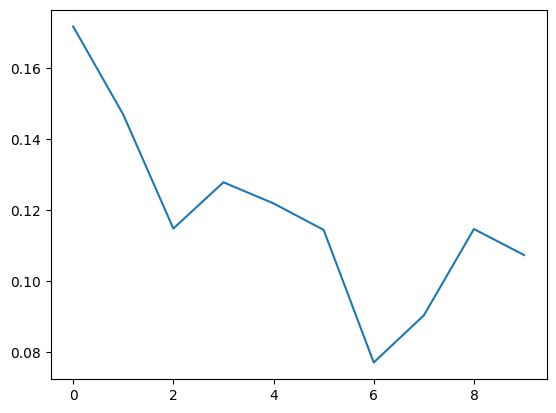

In [ ]:
net = FCN_dropout()
loss_arr = []

optimizer = optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(10):
  for i in range(n_batchs):
    x = X_train[i*batch_size: (i+1) * batch_size]
    y = Y_train[i*batch_size: (i+1) * batch_size].reshape((-1, 1))

    out = net(x)
    optimizer.zero_grad()
    loss = loss_fnc(out, y)
    loss.backward()
    optimizer.step()

  loss_arr.append(loss.detach())

plt.plot(range(len(loss_arr)), loss_arr)
plt.show()

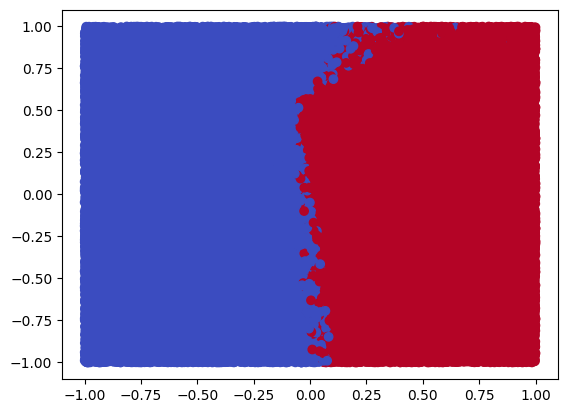

In [ ]:
Decision_Boundary(X_train, net)